In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from numpy.random import RandomState
from scipy import stats

In [2]:
def metropolis_hastings(uniform_rng, chain_start, n, logtarget, candidate_generating_density):
    x = chain_start
    chain = np.zeros(2 * n).reshape(2,n)
    accepted = 0
    
    for i in range(n):
        candidate = candidate_generating_density(x)
        
        if np.log(uniform_rng.uniform()) < logtarget(candidate) - logtarget(x):
            x = candidate
            accepted += 1
        
        chain[:,i] = x.reshape(2,)
        
    print(f"Hyväksyttyjä kandidaatteja: {(accepted/n)*100:.1f} %")
    return chain

In [3]:
uniform_rng = RandomState(1729)
proposal_rng = RandomState(2)

mu = np.array([[1], [2]])
sigma = np.array([[1, 0.9], [0.9, 1]])
sigma_inverse = np.linalg.inv(sigma)

# Multinormaalijakauman tiheysfunktion logaritmi ilman normalisointivakioita
logtarget = lambda x: -0.5 * np.transpose(x - mu) @ sigma_inverse @ (x - mu)
# Autoregressive generating density
proposal_density = lambda x: mu - (x - mu) + proposal_rng.uniform(low=-1, high=1, size=2).reshape(2,1)

chain = metropolis_hastings(uniform_rng, np.array([[1.0], [2.0]]), 100_000, logtarget, proposal_density)
print(f"Ketjun muoto {chain.shape}")

chain_without_burn_in = chain[:, chain.shape[1] // 2:]
print(f"Ketjun muoto burn-in jakson poiston jälkeen {chain_without_burn_in.shape}")
chain_with_gaps = chain_without_burn_in[:,::10]
print(f"Ketjun joka kymmenenne havainnon ottamisen jälkeen {chain_with_gaps.shape}")

Hyväksyttyjä kandidaatteja: 47.0 %
Ketjun muoto (2, 100000)
Ketjun muoto burn-in jakson poiston jälkeen (2, 50000)
Ketjun joka kymmenenne havainnon ottamisen jälkeen (2, 5000)


In [4]:
scipy_multinormal = multivariate_normal.rvs(mean=mu.reshape(2,), cov=sigma, size=5000, random_state=RandomState(99)).T
print(scipy_multinormal.shape)

(2, 5000)


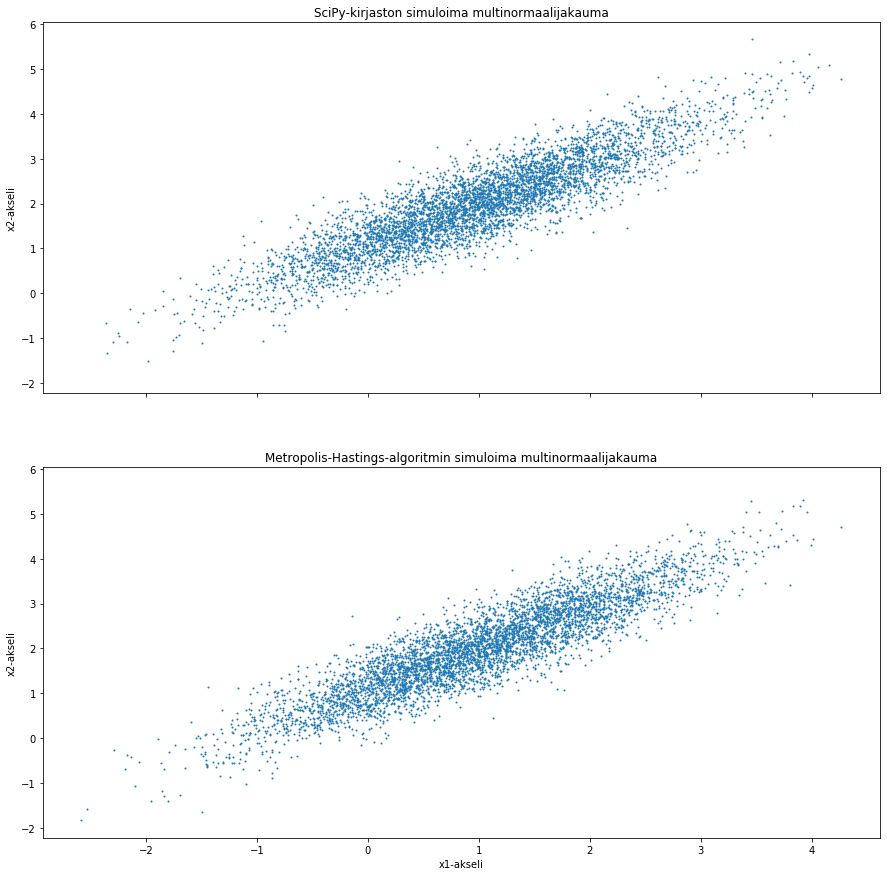

In [5]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)

ax[0].scatter(scipy_multinormal[0], scipy_multinormal[1], s=1)
ax[0].set_title("SciPy-kirjaston simuloima multinormaalijakauma")

ax[1].scatter(chain_with_gaps[0,:], chain_with_gaps[1,:], s=1)
ax[1].set_title("Metropolis-Hastings-algoritmin simuloima multinormaalijakauma")

for axis in ax.flat:
    axis.set(xlabel='x1-akseli', ylabel='x2-akseli')
    axis.label_outer()
    
plt.show()

In [6]:
scipy_multi = scipy_multinormal[:,:100]
print(scipy_multi.shape)
stats.shapiro(scipy_multi)

(2, 100)


(0.9911209940910339, 0.2588726282119751)

In [7]:
gaps = chain_with_gaps[:,:100]
print(gaps.shape)
stats.shapiro(gaps)

(2, 100)


(0.9928610920906067, 0.44237571954727173)

Hyväksyttyjä kandidaatteja: 48.7 %
(2, 1000)

Avg: 0.969768746571019
Shapiro p-value: 0.07312456518411636
AndersonResult(statistic=0.9256948413850523, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Avg: 2.038232798207335
Shapiro p-value: 0.3975096344947815
AndersonResult(statistic=0.22362588145688278, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


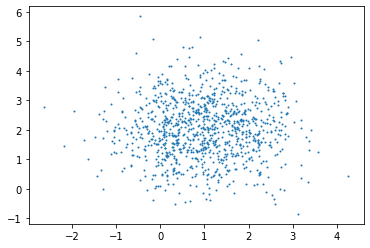

In [8]:
mu = np.array([[1], [2]])
sigma = np.array([[1.0, 0.0], [0.0, 1.0]])
# print(sigma)
sigma_inverse = np.linalg.inv(sigma)

# Multinormaalijakauman tiheysfunktion logaritmi ilman normalisointivakioita
logtarget = lambda x: -0.5 * np.transpose(x - mu) @ sigma_inverse @ (x - mu)
# Autoregressive generating density
proposal_density = lambda x: mu - (x - mu) + 1.9*RandomState().uniform(low=-1, high=1, size=2).reshape(2,1)
chain = metropolis_hastings(RandomState(), np.array([[1.0], [2.0]]), 20_000, logtarget, proposal_density)
without = chain[:, 10_000:]
gaps = without[:,::10]
print(gaps.shape)

print()
# print(gaps[0, :])
print(f"Avg: {np.average(gaps[0,:])}")
_, p_value1 = stats.shapiro(gaps[0,:])
print(f"Shapiro p-value: {p_value1}")
print(stats.anderson(gaps[0,:], dist="norm"))

print()
#print(gaps[1, :])
print(f"Avg: {np.average(gaps[1,:])}")
_, p_value2 = stats.shapiro(gaps[1,:])
print(f"Shapiro p-value: {p_value2}")
print(stats.anderson(gaps[1,:], dist="norm"))

plt.scatter(gaps[0], gaps[1], s=1)
plt.show()